## xcube Data Cube Generator Service

This notebook provides a walk-through demonstrating how to use the _data cube generator service_.

An introduction to the xcube data cube generators can be found in the [Getting Started](./1_getting_started.ipynb) Notebook.
The data cube generator service demonstrated here is a Python client for the [xcube Generator service API](https://stage.xcube-gen.brockmann-consult.de/api/v2/ui/).

Service processing units and credentials can be obtained by purchasing the API Service **xcube Generator** from the [EuroDataCube Marketplace](https://www.eurodatacube.com/marketplace).

The Python client is represented by the class `CubeGeneratorService`. Instances of this are created by passing it a 
`CubeGeneratorRequest` and a `ServiceConfig` instance. Here are imports for the named classes:

In [1]:
from xcube.core.gen2 import CubeGeneratorRequest
from xcube.core.gen2.service import CubeGeneratorService
from xcube.core.gen2.service import ServiceConfig

We first need to provide `client_id` and `client_secret` to authorize for using the service. 
An `endpoint_url` is optional and defaults to the standard endpoint for the EuroDataCube cube generation service.

In [2]:
service_config_json = {
    "client_id": "...",
    "client_secret": "..."
}

However, it is much saver to ingest service configuration from a JSON or YAML file (the file path used must be adjusted):

In [3]:
import yaml
with open('../../../edc-service.yml') as fp:
    service_config_json = yaml.safe_load(fp)

Validate and convert `service_config_json` to a service configuration object:

In [4]:
service_config = ServiceConfig.from_dict(service_config_json)

Now we define the _cube generator request_. 
The following example is supposed to read an `S2L2A` dataset from the **Sentinel Hub** data store (`input_config`), 
using numerous target cube parameters(`cube_config`), and
writes the target cube to a well-known scratch **bucket in AWS S3** (`output_config`).

This is how a _cube generator request_ looks as a (JSON) dictionary:

In [5]:
request_json = {
  "input_config": {
    "store_id": "@sentinelhub_eu",
    "data_id": "S2L2A"
  },
  "cube_config": {
    "variable_names": ["B04", "B05"],
    "bbox": [7, 53, 9, 55],
    "spatial_res": 0.001,
    "tile_size": [1024, 1024],
    "crs": "WGS84",
    "time_range": ["2019-08-05", "2019-08-10"],
    "time_period": "1D"
  },
  "output_config": {
    "store_id": "@eurodatacube_scratch",
    "data_id": "S2L2A_B04_B05_7_53_9_55.zarr",
    "replace": True
  }
}

Validate and convert `request_json` to a request object:

In [6]:
request = CubeGeneratorRequest.from_dict(request_json)
request

Instantiate the generator object:

In [7]:
gen = CubeGeneratorService(request, service_config, verbosity=1)

Get some information about the cube that would be generated by `gen` (this may take several seconds to complete):

In [8]:
cube_info = gen.get_cube_info()
cube_info

Now perform the actual cube generation (this may take up to a minute):

In [9]:
cube_id = gen.generate_cube()
cube_id

'S2L2A_B04_B05_7_53_9_55.zarr'

Let's open the generated cube. Cubes generated into the store "@eurodatacube_scratch" 
can be accessed via URL template "https://s3.eu-central-1.amazonaws.com/eurodatacube-scratch/{cube_id}":

In [10]:
from xcube.core.dsio import open_cube
cube = open_cube(f'https://s3.eu-central-1.amazonaws.com/eurodatacube-scratch/{cube_id}')
cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 2048, lon: 2048, time: 6)
Coordinates:
  * lat        (lat) float64 55.05 55.05 55.05 55.04 ... 53.0 53.0 53.0 53.0
  * lon        (lon) float64 7.0 7.002 7.002 7.003 ... 9.044 9.045 9.046 9.047
  * time       (time) datetime64[ns] 2019-08-05T12:00:00 ... 2019-08-10T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(6, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    date_created:              2021-04-23T07:52:23.611266
    geospatial_lat_max:        55.048
    geospatial_lat_min:        53.0
    geospatial_lon_max:        9.048
    geospatial_lon_min:        7.0
    ...                        ...
    processing_level:          L2A
    time_coverage_duration:    P6DT0H0M0S
    time_coverage_end:         2019-08-11T00:00:00+00:00
    time_coverage_resolution:  P1DT0H0M0S
    time_coverage_start:       2019-08-05T00:00:00+00:00
    title:                     S2L2A Data Cube Subset

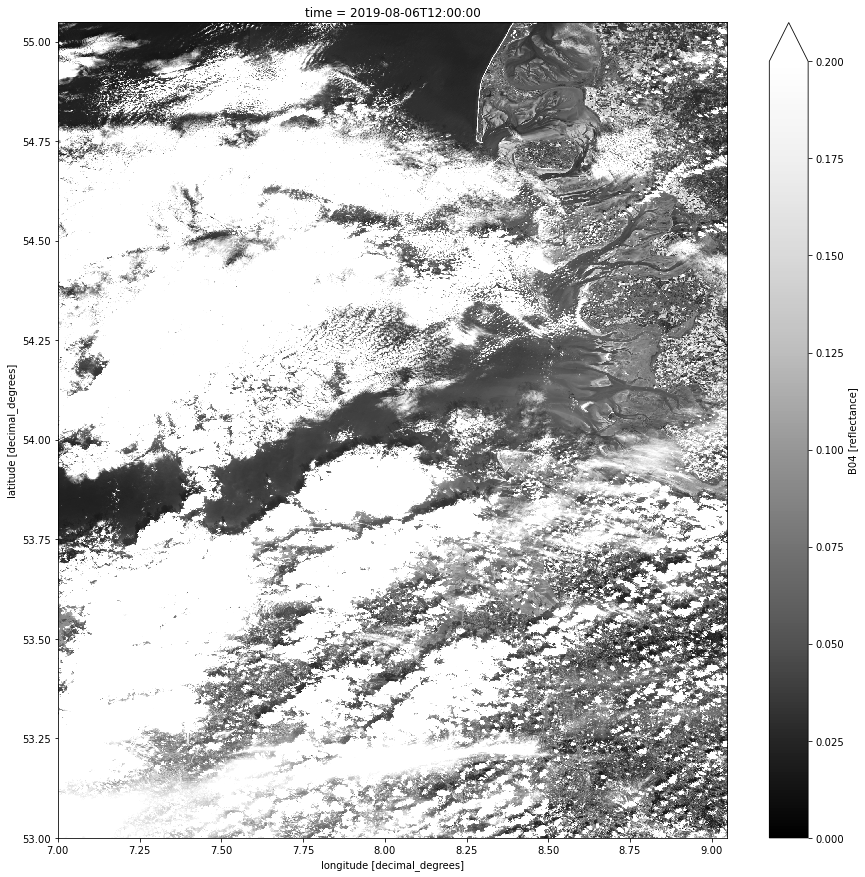

In [11]:
cube.B04.isel(time=1).plot.imshow(figsize=(15, 15), vmin=0, vmax=0.2, cmap='Greys_r')


_This is a work in progress. More material will follow in an upcoming xcube release._